# Loading Won Chang's MATLAB WRF data into Python

In [97]:
%pylab inline
import cartopy.crs as ccrs
import h5py

from scipy.io import loadmat
from scipy.ndimage import center_of_mass, label
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


The latlon.mat file is in the old MATLAB format, so we use scipy's loadmat package.

In [9]:
lat_lon = loadmat('latlon.mat')
lat_lon.keys()

dict_keys(['__header__', '__version__', '__globals__', 'lat0', 'lon0'])

The bottom code will load in a CCSM4*.mat information file. These newer .mat files are in hdf5 format, so we just use h5py. I also put in a loop to convert the datetimes to standard date formats.


In [64]:
# Load a file
file_path = './IdentificationResults/CCSM4_BC_Base_10_0.1_labeled_1995_rect.mat'
with h5py.File(file_path, mode='r') as f:
    data_dict = {}
    for my_key in f.keys():
        data_dict[my_key] = f[my_key][:].T
    
    data_dict['datetime'] = []
    data_dict['dvc'] = data_dict['dvc'].astype(int)
    for i in range(data_dict['dvc'].shape[0]):
        data_dict['datetime'].append(datetime(*data_dict['dvc'][i]))

Text(0.5, 1.0, '1995-01-17 06:00:00')

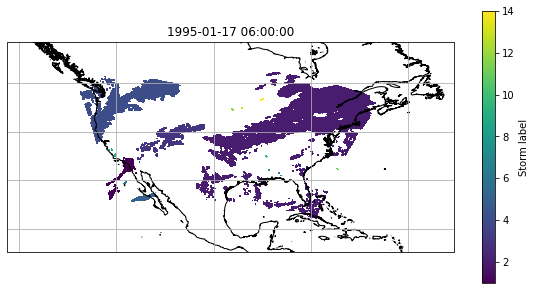

In [106]:
time_period = 130
input_array = data_dict['Y_labeled_each'][:, :, time_period]
input_array = np.where(input_array == 0, np.nan, input_array)
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
h = ax.pcolormesh(lat_lon['lon0'], lat_lon['lat0'], input_array)
plt.colorbar(h, ax=ax, label='Storm label')
ax.coastlines(resolution='10m')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.gridlines()
ax.set_title(data_dict['datetime'][time_period])

Code to find region centers of mass.

In [118]:
resolution = 4
time_period = 110
center_of_masses = []
areas = []
number_of_regions = []
for region in range(1, int(data_dict['Y_labeled_each'][:, :, time_period].max())):
    new_array = np.where(data_dict['Y_labeled_each'][:, :, time_period] == region, 1, 0)
    center_of_mass1 = center_of_mass(new_array)
    center_of_masses.append(center_of_mass1)
    areas.append(np.sum(new_array) * resolution**2)
    labels, num_features = label(new_array)
    number_of_regions.append(num_features)
    
    # Interpolate lat lon location:
lon_lats = []
for x, y in center_of_masses:
    x_min = math.floor(x)
    x_dist = x - x_min
    y_min = math.floor(y)
    y_dist = y - y_min
    lon = x_dist*(lat_lon['lon0'][x_min+1, y_min] - lat_lon['lon0'][x_min, y_min]) + lat_lon['lon0'][x_min, y_min]
    lat = y_dist*(lat_lon['lat0'][x_min, y_min+1] - lat_lon['lat0'][x_min, y_min]) + lat_lon['lat0'][x_min, y_min]
    lon_lats.append((lon, lat))
print(lon_lats)
print(areas)
print(number_of_regions)

[(-95.97643319468234, 32.86493696460962), (-89.98641912896673, 27.739162239280496), (-118.66929931640625, 32.105252642822265), (-99.92933649198679, 43.06176015822337), (-79.91715402481992, 33.63932835601419), (-120.44274681947749, 49.96839508288429), (-118.24398576785356, 27.436294438288762), (-101.88273620605469, 30.369815826416016), (-99.98046875, 32.04072189331055), (-84.37969970703125, 29.913463592529297), (-119.37425486246745, 37.34263292948405), (-98.95611572265625, 40.039241790771484), (-82.3463875906808, 45.26896286010742), (-98.05176798502605, 52.13823955441699), (-81.49946175634334, 49.02204712724264), (-70.49815877278647, 47.292606353759766), (-74.4927978515625, 48.65669059753418)]
[35904, 32032, 10000, 126736, 35264, 62144, 3120, 32, 96, 16, 384, 160, 112, 5184, 1808, 96, 32]
[27, 151, 11, 10, 39, 7, 91, 2, 1, 1, 4, 1, 1, 3, 1, 1, 1]


Text(0.5, 1.0, '1995-01-23 12:00:00')

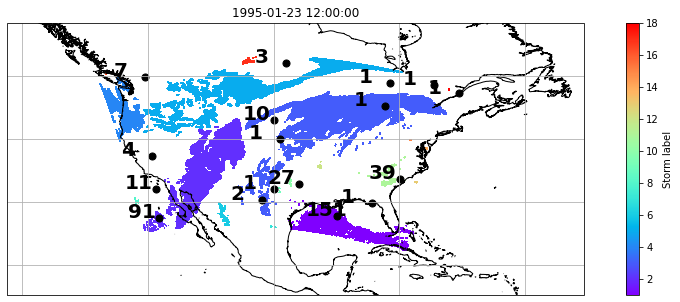

In [134]:
time_period = 180
input_array = data_dict['Y_labeled_each'][:, :, time_period]
input_array = np.where(input_array == 0, np.nan, input_array)
fig = plt.figure(figsize=(15, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
h = ax.pcolormesh(lat_lon['lon0'], lat_lon['lat0'], input_array, cmap='rainbow')
i = 0
for x, y in lon_lats:
    ax.scatter(x, y, s=50, color='k')
    ax.text(x-5, y, '%d' % number_of_regions[i], fontweight='bold', fontsize=20)
    i += 1
plt.colorbar(h, ax=ax, label='Storm label')
ax.coastlines(resolution='10m')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.gridlines()
ax.set_title(data_dict['datetime'][time_period])